In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Parse the json file and add new columns

In [27]:
with open('spacex_launches.json', 'r') as file:
    data = json.load(file)

# Normalize JSON data into a flat table
df = pd.json_normalize(data)

# Remove rows where 'id' is null
df = df.dropna(subset=['id'])
print("No nulls in df['id']")

# Convert 'date_utc' to datetime
df['date_utc'] = pd.to_datetime(df['date_utc'])

# Add Launch Year and Launch Month
df['launch_year'] = df['date_utc'].dt.year
df['launch_month'] = df['date_utc'].dt.month

# Add Launch Success as a categorical column
df['launch_success'] = df['success'].apply(lambda x: 'Succsess' if x else 'Failure')

No nulls in df['id']


## Lanuches per year



/var/folders/29/sxb8gb2n0cb07_td8p_t9pjw0000gn/T/ipykernel_50116/849619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=launches_per_year.index, y=launches_per_year.values, palette="Blues_d")


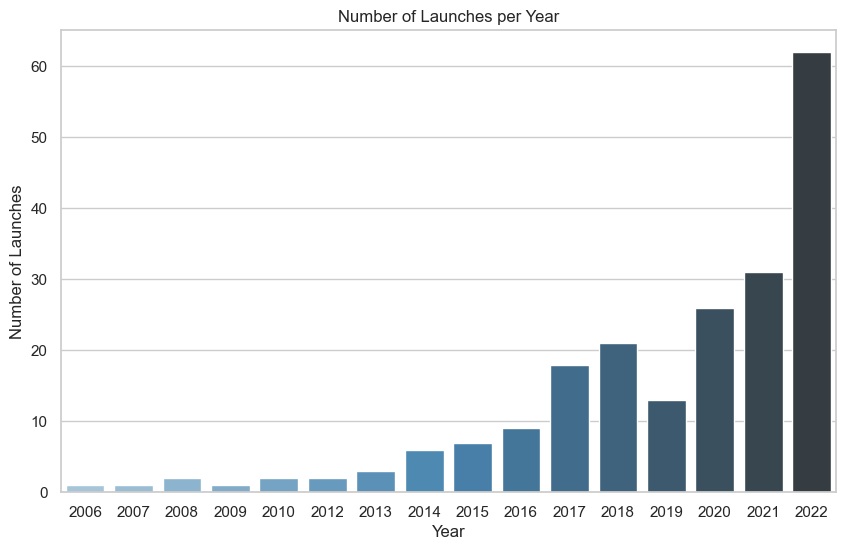

In [7]:
sns.set(style="whitegrid")
launches_per_year = df['launch_year'].value_counts().sort_index()
launches_per_month = df.groupby(['launch_year', 'launch_month']).size().reset_index(name='launch_count')

plt.figure(figsize=(10,6))
sns.barplot(x=launches_per_year.index, y=launches_per_year.values, palette="Blues_d")
plt.title('Number of Launches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.show()

## analyze cores

In [25]:
cores_expanded = df.explode('cores').reset_index(drop=True)
cores_data = pd.json_normalize(cores_expanded['cores'])
cores_df = pd.concat([cores_expanded['id'], cores_data], axis=1)
cores_df.rename(columns={'core': 'core_id'}, inplace=True)
#How freequently are cores reused?

core_id_counts = cores_df['core_id'].value_counts().reset_index(name='counts')


/var/folders/29/sxb8gb2n0cb07_td8p_t9pjw0000gn/T/ipykernel_50116/137326970.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=core_id_counts_sorted, x='core_id', y='counts', palette='viridis')


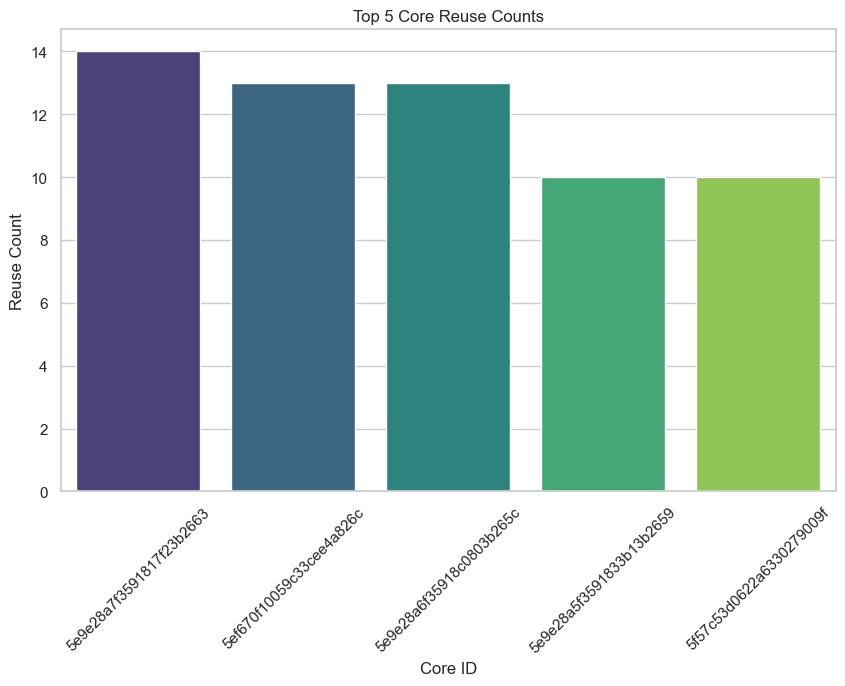

In [20]:
plt.figure(figsize=(10,6))
core_id_counts_sorted = core_id_counts.sort_values(by='counts', ascending=False).head(5)
sns.barplot(data=core_id_counts_sorted, x='core_id', y='counts', palette='viridis')
plt.title('Top 5 Core Reuse Counts')
plt.xlabel('Core ID')
plt.ylabel('Reuse Count')
plt.xticks(rotation=45)
plt.show()

## quick core reuse analysis

In [23]:
# join cores df on the original df to get the date_utc
joined_df = pd.merge(cores_df, df[['id', 'date_utc']], left_on='id', right_on='id', how='left')
cores_df_sorted = joined_df.sort_values(['core_id', 'date_utc'])

# add new column pointing to the preveious day 
cores_df_sorted['previous_day'] = cores_df_sorted.groupby('core_id')['date_utc'].shift(1)
cores_df_sorted['date_diff'] = (cores_df_sorted['date_utc'] - cores_df_sorted['previous_day']).dt.days
# sort by the date diff to identify rows with the lowest differente between  launch dates 

cores_df_sorted = cores_df_sorted.sort_values('date_diff', ascending=True).dropna(subset=['date_diff'])


/var/folders/29/sxb8gb2n0cb07_td8p_t9pjw0000gn/T/ipykernel_50116/808866685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cores_df_sorted.head(5), x='core_id', y='date_diff', palette='viridis')


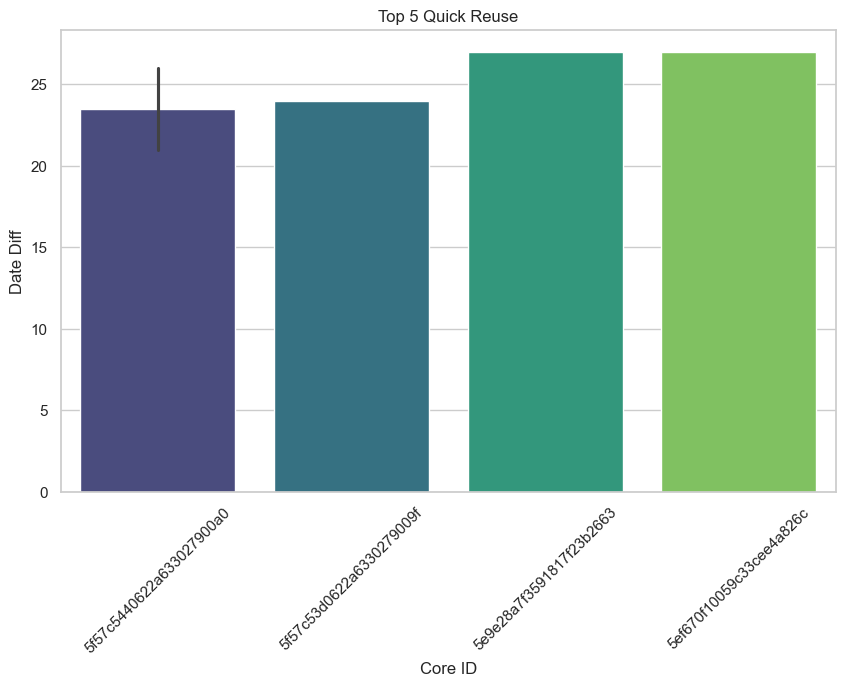

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=cores_df_sorted.head(5), x='core_id', y='date_diff', palette='viridis')
plt.title('Top 5 Quick Reuse')
plt.xlabel('Core ID')
plt.ylabel('Date Diff')
plt.xticks(rotation=45)
plt.show()

## busy launch months

In [30]:
launches_per_month = df.groupby(['launch_year', 'launch_month'])['id'].count().reset_index(name='launch_count').sort_values('launch_count', ascending=False)


/var/folders/29/sxb8gb2n0cb07_td8p_t9pjw0000gn/T/ipykernel_50116/845612560.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y='launch_count', data=launches_per_month, palette="Blues_d")


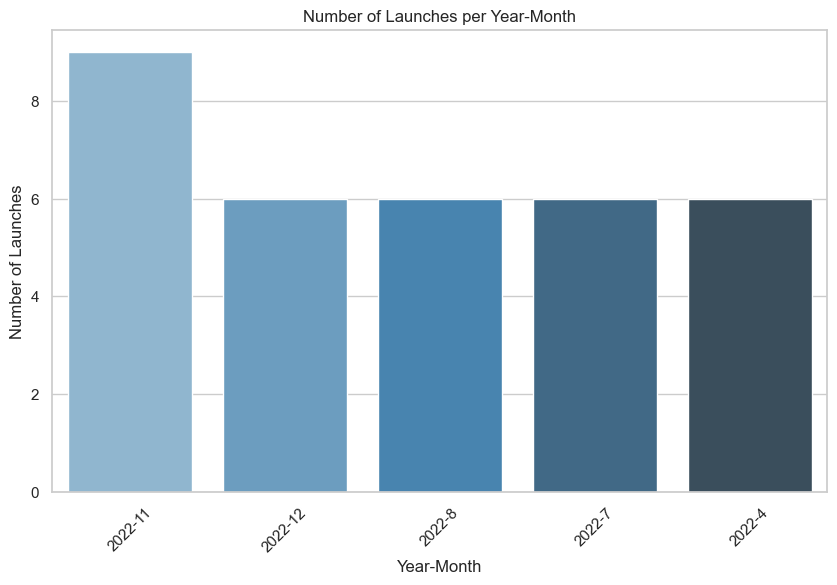

In [28]:
plt.figure(figsize=(10,6))
launches_per_month['date'] = launches_per_month['launch_year'].astype(str) + '-' + launches_per_month['launch_month'].astype(str).head(5)
sns.barplot(x='date', y='launch_count', data=launches_per_month, palette="Blues_d")
plt.title('Number of Launches per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Launches')
plt.xticks(rotation=45)
plt.show()

## average days between launches 

In [29]:
avg_days = cores_df_sorted['date_diff'].mean()
print(f'Average days between launches: {avg_days:.2f} days')

Average days between launches: 118.80 days


## succsessful rate per launchpad

In [18]:
success_counts = df[df['launch_success'] == 'Succsess'].groupby('launchpad').size().reset_index(name='successful')
total_counts = df.groupby('launchpad').size().reset_index(name='total')

# Merge the two DataFrames
success_rates = pd.merge(total_counts, success_counts, on='launchpad', how='left').fillna(0)

# Calculate success rate
success_rates['rate'] = (success_rates['successful'] / success_rates['total']) * 100



/var/folders/29/sxb8gb2n0cb07_td8p_t9pjw0000gn/T/ipykernel_50116/4013813864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rates_sorted, x='launchpad', y='rate', palette='viridis')


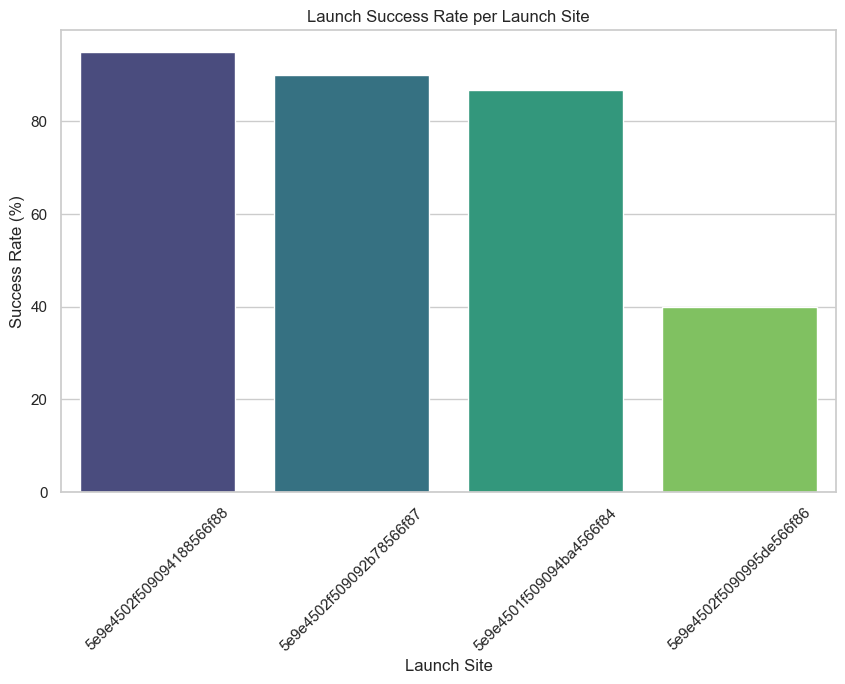

In [12]:
plt.figure(figsize=(10,6))
success_rates_sorted = success_rates.sort_values(by='rate', ascending=False)
sns.barplot(data=success_rates_sorted, x='launchpad', y='rate', palette='viridis')
plt.title('Launch Success Rate per Launch Site')
plt.xlabel('Launch Site')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)
plt.show()